In [1]:
import os
import tensorflow as tf
import malaya
import json
import matplotlib.pyplot as plt

In [2]:
import re

tokenizer = malaya.preprocessing._SocialTokenizer().tokenize

def is_number_regex(s):
    if re.match("^\d+?\.\d+?$", s) is None:
        return s.isdigit()
    return True

def detect_money(word):
    if word[:2] == 'rm' and is_number_regex(word[2:]):
        return True
    else:
        return False

def preprocessing(string):
    tokenized = tokenizer(string)
    tokenized = [malaya.stem.naive(w) for w in tokenized]
    tokenized = [w.lower() for w in tokenized if len(w) > 1]
    tokenized = ['<NUM>' if is_number_regex(w) else w for w in tokenized]
    tokenized = ['<MONEY>' if detect_money(w) else w for w in tokenized]
    return tokenized

def clean_label(label):
    string = re.sub('[^A-Za-z\- ]+', ' ', label)
    return re.sub(r'[ ]+', ' ', string.lower()).strip()

In [3]:
with open('augmented-relevancy.json') as fopen:
    loaded = json.load(fopen)
    
X = loaded['X']
Y = loaded['Y']
del loaded
del X

In [4]:
len(Y)

209519

In [5]:
with open('tokenized.json') as fopen:
    X = json.load(fopen)
len(X)

209519

In [6]:
def build_dataset(words, n_words, atleast=5):
    count = [['PAD', 0], ['GO', 1], ['EOS', 2], ['UNK', 3]]
    counter = collections.Counter(words).most_common(n_words - 10)
    counter = [i for i in counter if i[1] >= atleast]
    count.extend(counter)
    dictionary = dict()
    for word, _ in count:
        dictionary[word] = len(dictionary)
    data = list()
    unk_count = 0
    for word in words:
        index = dictionary.get(word, 0)
        if index == 0:
            unk_count += 1
        data.append(index)
    count[0][1] = unk_count
    reversed_dictionary = dict(zip(dictionary.values(), dictionary.keys()))
    return data, count, dictionary, reversed_dictionary

In [7]:
import itertools
import collections

concat = list(itertools.chain(*X))
vocabulary_size = len(list(set(concat)))
data, count, dictionary, rev_dictionary = build_dataset(concat, vocabulary_size, 1)
print('vocab from size: %d'%(vocabulary_size))
print('Most common words', count[4:10])
print('Sample data', data[:10], [rev_dictionary[i] for i in data[:10]])
len(dictionary)

vocab from size: 182897
Most common words [('yang', 3183855), ('untuk', 1605026), ('deng', 1044792), ('<NUM>', 990691), ('pada', 946745), ('saya', 881156)]
Sample data [11, 37, 37, 4, 961, 4570, 4006, 374, 639, 388] ['dalam', 'masa', 'masa', 'yang', 'cabar', 'jackie', 'mason', 'wakili', 'suara', 'bab']


182891

In [8]:
with open('relevancy-dictionary.json','w') as fopen:
    fopen.write(json.dumps({'dictionary':dictionary,'reverse_dictionary':rev_dictionary}))

In [9]:
import numpy as np

In [10]:
def position_encoding(inputs):
    T = tf.shape(inputs)[1]
    repr_dim = inputs.get_shape()[-1].value
    pos = tf.reshape(tf.range(0.0, tf.to_float(T), dtype=tf.float32), [-1, 1])
    i = np.arange(0, repr_dim, 2, np.float32)
    denom = np.reshape(np.power(10000.0, i / repr_dim), [1, -1])
    enc = tf.expand_dims(tf.concat([tf.sin(pos / denom), tf.cos(pos / denom)], 1), 0)
    return tf.tile(enc, [tf.shape(inputs)[0], 1, 1])

def layer_norm(inputs, epsilon=1e-8):
    mean, variance = tf.nn.moments(inputs, [-1], keep_dims=True)
    normalized = (inputs - mean) / (tf.sqrt(variance + epsilon))
    params_shape = inputs.get_shape()[-1:]
    gamma = tf.get_variable('gamma', params_shape, tf.float32, tf.ones_initializer())
    beta = tf.get_variable('beta', params_shape, tf.float32, tf.zeros_initializer())
    return gamma * normalized + beta

def cnn_block(x, dilation_rate, pad_sz, hidden_dim, kernel_size):
    x = layer_norm(x)
    pad = tf.zeros([tf.shape(x)[0], pad_sz, hidden_dim])
    x =  tf.layers.conv1d(inputs = tf.concat([pad, x, pad], 1),
                          filters = hidden_dim,
                          kernel_size = kernel_size,
                          dilation_rate = dilation_rate)
    x = tf.layers.dropout(x, 0.3, training=True) 
    x = x[:, :-pad_sz, :]
    x = tf.nn.relu(x)
    return x

def Attention(inputs, num_units, num_heads = 8, activation = None):
    T_q = T_k = tf.shape(inputs)[1]
    Q_K_V = tf.layers.dense(inputs, 3*num_units, activation)
    Q, K, V = tf.split(Q_K_V, 3, -1)
    Q_ = tf.concat(tf.split(Q, num_heads, axis=2), 0)
    K_ = tf.concat(tf.split(K, num_heads, axis=2), 0)
    V_ = tf.concat(tf.split(V, num_heads, axis=2), 0)
    align = tf.matmul(Q_, K_, transpose_b=True)
    align *= tf.rsqrt(tf.to_float(K_.get_shape()[-1].value))
    paddings = tf.fill(tf.shape(align), float('-inf'))
    lower_tri = tf.ones([T_q, T_k])
    lower_tri = tf.linalg.LinearOperatorLowerTriangular(lower_tri).to_dense()
    masks = tf.tile(tf.expand_dims(lower_tri,0), [tf.shape(align)[0],1,1])
    align = tf.where(tf.equal(masks, 0), paddings, align)
    align = tf.nn.softmax(align)
    align = tf.layers.dropout(align, 0.3, training=True) 
    alignments = tf.transpose(align, [0, 2, 1]) 
    x = tf.matmul(align, V_)
    x = tf.concat(tf.split(x, num_heads, axis=0), 2)
    x += inputs
    x = layer_norm(x)
    return x, alignments

class Model:
    def __init__(self, dict_size, dimension_output, size_layer, num_layers, learning_rate,
                 kernel_size = 5):
        self.X = tf.placeholder(tf.int32, [None, None])
        self.Y = tf.placeholder(tf.int32, [None])
        
        embeddings = tf.Variable(
            tf.random_uniform([dict_size, size_layer], -1, 1)
        )
        x = tf.nn.embedding_lookup(embeddings, self.X)
        x += position_encoding(x)
        
        for i in range(num_layers): 
            dilation_rate = 2 ** i
            pad_sz = (kernel_size - 1) * dilation_rate 
            with tf.variable_scope('block_%d'%i):
                a = cnn_block(x, dilation_rate, pad_sz, size_layer, kernel_size)
            
            x += a
        print(x)
        train_R, self.alignments = Attention(x, size_layers)
        
        def logits(x, reuse = False):
            with tf.variable_scope('generate_mel', reuse = reuse):
                for i in range(num_layers): 
                    dilation_rate = 2 ** i
                    pad_sz = (kernel_size - 1) * dilation_rate 
                    with tf.variable_scope('block_mel_%d'%i, reuse = reuse):
                        x += cnn_block(x, dilation_rate, pad_sz, size_layer, kernel_size)
                return tf.layers.dense(x, dimension_output)
        
        self.logits_seq = logits(train_R)
        self.logits_seq = tf.identity(self.logits_seq, name = 'logits_seq')
        self.logits = self.logits_seq[:, -1]
        self.logits = tf.identity(self.logits, name = 'logits')
        print(self.logits)
        
        self.cost = tf.reduce_mean(
            tf.nn.sparse_softmax_cross_entropy_with_logits(
                logits = self.logits, labels = self.Y
            )
        )
        
        self.cost = self.cost
        self.optimizer = tf.train.AdamOptimizer(
            learning_rate = learning_rate
        ).minimize(self.cost)
        correct_pred = tf.equal(
            tf.argmax(self.logits, 1, output_type = tf.int32), self.Y
        )
        self.accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))
        self.attention = tf.identity(tf.reduce_mean(self.alignments[0], 1), name = 'alphas')

In [11]:
tf.reset_default_graph()
sess = tf.InteractiveSession()

size_layers = 128
learning_rate = 1e-4
num_layers = 6

model = Model(len(dictionary), 2, size_layers, num_layers, learning_rate)
sess.run(tf.global_variables_initializer())

Tensor("add_6:0", shape=(?, ?, 128), dtype=float32)
Tensor("logits:0", shape=(?, 2), dtype=float32)


In [12]:
strings = ','.join(
    [
        n.name
        for n in tf.get_default_graph().as_graph_def().node
        if ('Variable' in n.op
        or 'Placeholder' in n.name
        or 'logits' in n.name
        or 'logits_seq' in n.name
        or 'alphas' in n.name)
        and 'Adam' not in n.name
        and '_power' not in n.name
    ]
)
strings.split(',')

['Placeholder',
 'Placeholder_1',
 'Variable',
 'block_0/gamma',
 'block_0/beta',
 'block_0/conv1d/kernel',
 'block_0/conv1d/bias',
 'block_1/gamma',
 'block_1/beta',
 'block_1/conv1d/kernel',
 'block_1/conv1d/bias',
 'block_2/gamma',
 'block_2/beta',
 'block_2/conv1d/kernel',
 'block_2/conv1d/bias',
 'block_3/gamma',
 'block_3/beta',
 'block_3/conv1d/kernel',
 'block_3/conv1d/bias',
 'block_4/gamma',
 'block_4/beta',
 'block_4/conv1d/kernel',
 'block_4/conv1d/bias',
 'block_5/gamma',
 'block_5/beta',
 'block_5/conv1d/kernel',
 'block_5/conv1d/bias',
 'dense/kernel',
 'dense/bias',
 'gamma',
 'beta',
 'generate_mel/block_mel_0/gamma',
 'generate_mel/block_mel_0/beta',
 'generate_mel/block_mel_0/conv1d/kernel',
 'generate_mel/block_mel_0/conv1d/bias',
 'generate_mel/block_mel_1/gamma',
 'generate_mel/block_mel_1/beta',
 'generate_mel/block_mel_1/conv1d/kernel',
 'generate_mel/block_mel_1/conv1d/bias',
 'generate_mel/block_mel_2/gamma',
 'generate_mel/block_mel_2/beta',
 'generate_mel/bl

In [13]:
saver = tf.train.Saver(tf.trainable_variables())
saver.save(sess, 'dilated-cnn-monothonic-attention/model.ckpt')

'dilated-cnn-monothonic-attention/model.ckpt'

In [14]:
def str_idx(corpus, dic, maxlen, UNK = 3):
    X = np.zeros((len(corpus), maxlen))
    for i in range(len(corpus)):
        for no, k in enumerate(corpus[i][:maxlen]):
            X[i, no] = dic.get(k, UNK)
    return X

In [15]:
from sklearn.cross_validation import train_test_split

train_X, test_X, train_Y, test_Y = train_test_split(X, Y, test_size = 0.2)

del X, Y

In [16]:
len(train_X), len(test_X)

(167615, 41904)

In [17]:
batch_size = 16
max_x = 500

In [18]:
from tqdm import tqdm
import time

for EPOCH in range(5):
    lasttime = time.time()

    train_acc, train_loss, test_acc, test_loss = 0, 0, 0, 0
    pbar = tqdm(
        range(0, len(train_X), batch_size), desc = 'train minibatch loop'
    )
    for i in pbar:
        index = min(i + batch_size, len(train_X))
        batch_x = train_X[i : index]
        batch_y = train_Y[i : index]
        max_batch = max([len(x) for x in batch_x])
        max_batch = min(max_batch, max_x)
        batch_x = str_idx(batch_x, dictionary, max_batch)
        
        acc, cost, _ = sess.run(
            [model.accuracy, model.cost, model.optimizer],
            feed_dict = {
                model.Y: batch_y,
                model.X: batch_x
            },
        )
        assert not np.isnan(cost)
        train_loss += cost
        train_acc += acc
        pbar.set_postfix(cost = cost, accuracy = acc)
    
    pbar = tqdm(
        range(0, len(test_X), batch_size), desc = 'test minibatch loop'
    )
    for i in pbar:
        index = min(i + batch_size, len(test_X))
        batch_x = test_X[i : index]
        batch_y = test_Y[i : index]
        max_batch = max([len(x) for x in batch_x])
        max_batch = min(max_batch, max_x)
        batch_x = str_idx(batch_x, dictionary, max_batch)
        
        acc, cost = sess.run(
            [model.accuracy, model.cost],
            feed_dict = {
                model.Y: batch_y,
                model.X: batch_x,
            },
        )
        assert not np.isnan(cost)
        test_loss += cost
        test_acc += acc
        pbar.set_postfix(cost = cost, accuracy = acc)
    
    train_loss /= len(train_X) / batch_size
    train_acc /= len(train_X) / batch_size
    test_loss /= len(test_X) / batch_size
    test_acc /= len(test_X) / batch_size
        
    print('time taken:', time.time() - lasttime)
    print(
        'epoch: %d, training loss: %f, training acc: %f, valid loss: %f, valid acc: %f\n'
        % (EPOCH, train_loss, train_acc, test_loss, test_acc)
    )

train minibatch loop:   0%|          | 0/10476 [00:00<?, ?it/s]

time taken: 3068.936585664749
epoch: 0, training loss: 0.666421, training acc: 0.637842, valid loss: 0.554504, valid acc: 0.737949



train minibatch loop:   0%|          | 0/10476 [00:00<?, ?it/s]

time taken: 3065.2919266223907
epoch: 1, training loss: 0.400431, training acc: 0.823811, valid loss: 0.438235, valid acc: 0.826246



train minibatch loop:   0%|          | 0/10476 [00:00<?, ?it/s]

time taken: 3066.7117681503296
epoch: 2, training loss: 0.286431, training acc: 0.882248, valid loss: 0.359493, valid acc: 0.866910



train minibatch loop:   0%|          | 0/10476 [00:00<?, ?it/s]

time taken: 3066.253027200699
epoch: 3, training loss: 0.218694, training acc: 0.912502, valid loss: 0.278537, valid acc: 0.895642



test minibatch loop: 100%|██████████| 2619/2619 [04:08<00:00, 10.52it/s, accuracy=0.812, cost=0.31]  

time taken: 3066.1756496429443
epoch: 4, training loss: 0.167653, training acc: 0.934504, valid loss: 0.268135, valid acc: 0.908028



In [19]:
testing = 'Sesungguhnya menjadi tradisi, mana-mana calon presiden AS pasti perlu mendapat sokongan masyarakat Yahudi yang mengawal ekonomi di AS untuk jadi presiden, namun tidak ramai seberani Trump dalam mengotakan dan mengabui mata Yahudi dan Zionism Israel'
testing = preprocessing(testing)
t = testing
testing = str_idx([testing], dictionary, len(testing))

In [20]:
t

['sesungguh',
 'jadi',
 'tradisi',
 'mana',
 'mana',
 'calon',
 'presiden',
 'as',
 'pasti',
 'lu',
 'dapat',
 'sokong',
 'masyarakat',
 'yahudi',
 'yang',
 'awal',
 'ekonomi',
 'as',
 'untuk',
 'jadi',
 'presiden',
 'namun',
 'tidak',
 'ramai',
 'berani',
 'trump',
 'dalam',
 'ota',
 'abui',
 'mata',
 'yahudi',
 'zionism',
 'israel']

In [21]:
b, c, d = sess.run([tf.nn.softmax(model.logits), tf.nn.softmax(model.logits_seq), model.attention], 
                    feed_dict = {model.X: testing})

In [22]:
b

array([[0.10316102, 0.896839  ]], dtype=float32)

In [23]:
c

array([[[0.20458561, 0.7954144 ],
        [0.20891723, 0.7910828 ],
        [0.26299277, 0.7370072 ],
        [0.3115242 , 0.6884758 ],
        [0.12016144, 0.8798386 ],
        [0.2703326 , 0.72966737],
        [0.06844044, 0.93155956],
        [0.12700671, 0.8729933 ],
        [0.11655831, 0.8834416 ],
        [0.10850243, 0.89149755],
        [0.02827738, 0.9717226 ],
        [0.03893825, 0.9610617 ],
        [0.08950341, 0.9104966 ],
        [0.1154675 , 0.8845325 ],
        [0.02425126, 0.9757488 ],
        [0.190811  , 0.80918896],
        [0.05578459, 0.9442154 ],
        [0.09285109, 0.9071489 ],
        [0.02413037, 0.97586966],
        [0.23477283, 0.76522714],
        [0.06896605, 0.9310339 ],
        [0.13001539, 0.86998457],
        [0.05865331, 0.9413467 ],
        [0.16901633, 0.83098364],
        [0.13118097, 0.86881906],
        [0.05592104, 0.944079  ],
        [0.01630562, 0.9836944 ],
        [0.08250867, 0.9174914 ],
        [0.05632772, 0.9436723 ],
        [0.054

In [24]:
d

array([6.3174367e-02, 1.1996758e-01, 3.8123786e-02, 1.1450567e-01,
       1.6318941e-02, 3.3116754e-02, 9.3670673e-04, 7.3650993e-02,
       5.3818233e-02, 3.3894209e-03, 5.3144637e-02, 3.0739445e-02,
       1.2955000e-03, 2.8437456e-02, 1.6708038e-03, 1.2041924e-03,
       2.8376815e-01, 4.0264530e-03, 4.2755278e-03, 3.6988070e-03,
       1.8554095e-03, 5.6884525e-04, 2.4780640e-03, 6.3828900e-03,
       1.8300259e-02, 2.0665762e-03, 6.9348534e-05, 8.6902449e-04,
       8.6928689e-04, 4.4739057e-04, 1.8079695e-04, 1.8393457e-03,
       4.9551651e-05], dtype=float32)

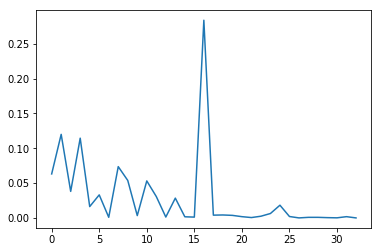

In [25]:
plt.plot(d)
plt.show()

In [26]:
saver.save(sess, 'dilated-cnn-monothonic-attention/model.ckpt')

'dilated-cnn-monothonic-attention/model.ckpt'

In [27]:
def freeze_graph(model_dir, output_node_names):

    if not tf.gfile.Exists(model_dir):
        raise AssertionError(
            "Export directory doesn't exists. Please specify an export "
            'directory: %s' % model_dir
        )

    checkpoint = tf.train.get_checkpoint_state(model_dir)
    input_checkpoint = checkpoint.model_checkpoint_path

    absolute_model_dir = '/'.join(input_checkpoint.split('/')[:-1])
    output_graph = absolute_model_dir + '/frozen_model.pb'
    clear_devices = True
    with tf.Session(graph = tf.Graph()) as sess:
        saver = tf.train.import_meta_graph(
            input_checkpoint + '.meta', clear_devices = clear_devices
        )
        saver.restore(sess, input_checkpoint)
        output_graph_def = tf.graph_util.convert_variables_to_constants(
            sess,
            tf.get_default_graph().as_graph_def(),
            output_node_names.split(','),
        )
        with tf.gfile.GFile(output_graph, 'wb') as f:
            f.write(output_graph_def.SerializeToString())
        print('%d ops in the final graph.' % len(output_graph_def.node))

In [28]:
freeze_graph('dilated-cnn-monothonic-attention', strings)

INFO:tensorflow:Restoring parameters from dilated-cnn-monothonic-attention/model.ckpt
INFO:tensorflow:Froze 55 variables.
INFO:tensorflow:Converted 55 variables to const ops.
1462 ops in the final graph.


In [29]:
def load_graph(frozen_graph_filename):
    with tf.gfile.GFile(frozen_graph_filename, 'rb') as f:
        graph_def = tf.GraphDef()
        graph_def.ParseFromString(f.read())
    with tf.Graph().as_default() as graph:
        tf.import_graph_def(graph_def)
    return graph

In [30]:
g = load_graph('dilated-cnn-monothonic-attention/frozen_model.pb')

In [31]:
x = g.get_tensor_by_name('import/Placeholder:0')
logits = g.get_tensor_by_name('import/logits:0')
logits_seq = g.get_tensor_by_name('import/logits_seq:0')
alphas = g.get_tensor_by_name('import/alphas:0')

In [32]:
test_sess = tf.InteractiveSession(graph = g)
result = test_sess.run([tf.nn.softmax(logits), tf.nn.softmax(logits_seq),
                       alphas], feed_dict = {x: testing})

In [33]:
result[0]

array([[0.21157387, 0.7884261 ]], dtype=float32)

In [34]:
result[1]

array([[[0.3625717 , 0.63742834],
        [0.25559983, 0.7444002 ],
        [0.13985643, 0.8601436 ],
        [0.10029418, 0.8997058 ],
        [0.12047913, 0.8795209 ],
        [0.37683952, 0.62316054],
        [0.16374183, 0.8362582 ],
        [0.14067769, 0.8593223 ],
        [0.15781894, 0.842181  ],
        [0.0505404 , 0.9494597 ],
        [0.14093234, 0.8590677 ],
        [0.1981986 , 0.8018014 ],
        [0.05592136, 0.9440786 ],
        [0.07287309, 0.9271269 ],
        [0.07496343, 0.92503655],
        [0.0328363 , 0.9671637 ],
        [0.09447112, 0.9055289 ],
        [0.10212212, 0.8978779 ],
        [0.03378407, 0.96621597],
        [0.2547615 , 0.74523854],
        [0.10710595, 0.892894  ],
        [0.17671536, 0.82328457],
        [0.22523351, 0.7747665 ],
        [0.20721424, 0.79278576],
        [0.255706  , 0.744294  ],
        [0.2150419 , 0.7849581 ],
        [0.06138707, 0.93861294],
        [0.08178228, 0.91821766],
        [0.16665268, 0.8333473 ],
        [0.196

In [35]:
result[2]

array([2.2620583e-02, 1.6652049e-01, 8.3995678e-02, 4.7080241e-02,
       1.8529581e-01, 5.3071108e-02, 9.2920857e-03, 5.7690583e-02,
       7.4108988e-02, 2.0292872e-03, 9.6523352e-02, 3.0451301e-02,
       1.5304149e-03, 1.0427203e-02, 6.1753928e-04, 6.6924295e-03,
       5.8200452e-02, 2.4306070e-02, 1.2170180e-03, 7.0542404e-03,
       9.8375918e-04, 7.9721812e-04, 9.5459344e-03, 2.9507747e-02,
       4.8530661e-03, 1.9742327e-03, 2.5347765e-03, 3.0792286e-03,
       1.9981235e-02, 7.3444224e-03, 3.9411717e-04, 5.3197327e-05,
       0.0000000e+00], dtype=float32)